<a href="https://colab.research.google.com/github/Danis2019/Funny_neural_network/blob/main/Rushan_or_Danis_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание собак и кошек на изображениях с помощью предварительно обученной нейронной сети VGG16

**Источник данных** - соревнования Kaggle [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data).

Для распознавания используется предварительно обученная сверточная нейронная сеть VGG16.

Перед использованием необходимо скачать и подготовить данные для обучения, проверки и тестирования. Можно использовать пример в ноутбуке data_preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

In [5]:
# Каталог с данными для обучения
train_dir = '/content/drive/MyDrive/new_datasets/train'
# Каталог с данными для проверки
val_dir = '/content/drive/MyDrive/new_datasets/val'
# Каталог с данными для тестирования
test_dir = '/content/drive/MyDrive/new_datasets/test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (None, img_width, img_height, 3)
# Размер мини-выборки
batch_size = 2
# Количество изображений для обучения
nb_train_samples = 17
# Количество изображений для проверки
nb_validation_samples = 3
# Количество изображений для тестирования
nb_test_samples = 3

## Загружаем предварительно обученную нейронную сеть

In [6]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


"Замораживаем" веса предварительно обученной нейронной сети VGG16

In [7]:
vgg16_net.trainable = False

In [8]:
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Создаем составную нейронную сеть на основе VGG16

In [9]:
model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [10]:
model.build(input_shape)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

Компилируем составную нейронную сеть

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer= "adam", 
              metrics=['accuracy'])

## Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.

In [13]:
datagen = ImageDataGenerator(rescale=1. / 255)


Генератор данных для обучения на основе изображений из каталога

In [14]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 38 images belonging to 2 classes.


Генератор данных для проверки на основе изображений из каталога

In [15]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 38 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога

In [16]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 38 images belonging to 2 classes.


## Обучаем модель с использованием генераторов

train_generator - генератор данных для обучения

validation_data - генератор данных для проверки

In [17]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
8/8 [==============================] - 33s 4s/step - loss: 2.8575 - accuracy: 0.6250 - val_loss: 1.8541 - val_accuracy: 0.0000e+00
Epoch 2/5
8/8 [==============================] - 16s 2s/step - loss: 0.4202 - accuracy: 0.8125 - val_loss: 0.1096 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 16s 2s/step - loss: 0.2983 - accuracy: 0.8125 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 18s 2s/step - loss: 0.2187 - accuracy: 0.8750 - val_loss: 6.8416e-04 - val_accuracy: 1.0000
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.7810e-05 - val_accuracy: 1.0000


# Вывожу веса

In [18]:
weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

# Выводим сразу изображение

In [19]:
from keras.preprocessing import image
import numpy as np
from IPython.display import Image

In [20]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [21]:
img_path = "iarik.jpg"
new_image = load_image(img_path)

pred = model.predict_classes(new_image)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


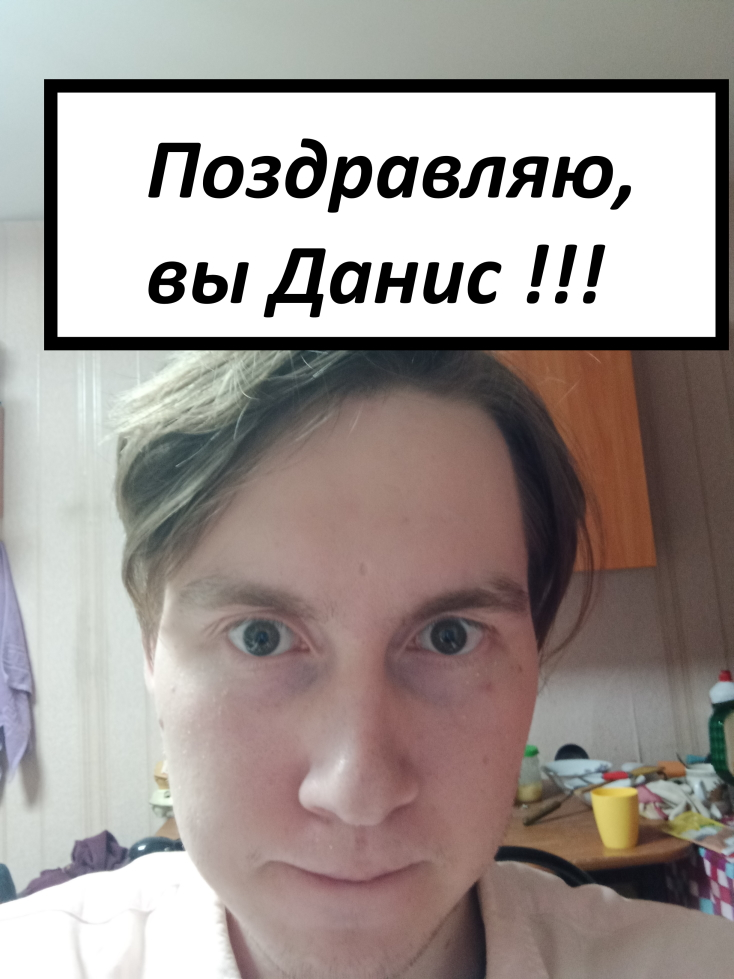

In [23]:
if pred[0][0] == 1:
  display(Image(filename='rushan1.jpg'))
else:
  display(Image(filename='danis1.jpg'))

## Оцениваем качество работы сети с помощью генератора

In [ ]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1996: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 100.00%


# Тонкая настройка сети (fine tuning)

"Размораживаем" последний сверточный блок сети VGG16

In [ ]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable    

In [ ]:
# Проверяем количество обучаемых параметров
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam", 
              metrics=['accuracy'])

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=2,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
8/8 [==============================] - 9s 958ms/step - loss: 20.1324 - accuracy: 0.7500 - val_loss: 0.0589 - val_accuracy: 1.0000
Epoch 2/2
8/8 [==============================] - 7s 888ms/step - loss: 2.9511 - accuracy: 0.7500 - val_loss: 2.8022e-12 - val_accuracy: 1.0000


In [ ]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1996: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Аккуратность на тестовых данных: 100.00%
